Loading train/test splits...
Starting repeated sub-sampling with GridSearch for Random Forest...

--- Seed 0 ---

--- Seed 1 ---

--- Seed 2 ---

--- Seed 3 ---

--- Seed 4 ---

--- Seed 5 ---

--- Seed 6 ---

--- Seed 7 ---

--- Seed 8 ---

--- Seed 9 ---

--- Seed 10 ---

--- Seed 11 ---

--- Seed 12 ---

--- Seed 13 ---

--- Seed 14 ---

--- Seed 15 ---

--- Seed 16 ---

--- Seed 17 ---

--- Seed 18 ---

--- Seed 19 ---

Classification Report (best F1 across seeds):
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       719
           1       0.27      0.67      0.39       129

    accuracy                           0.68       848
   macro avg       0.60      0.68      0.58       848
weighted avg       0.82      0.68      0.72       848



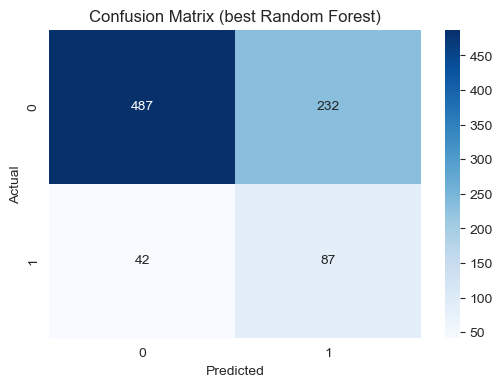

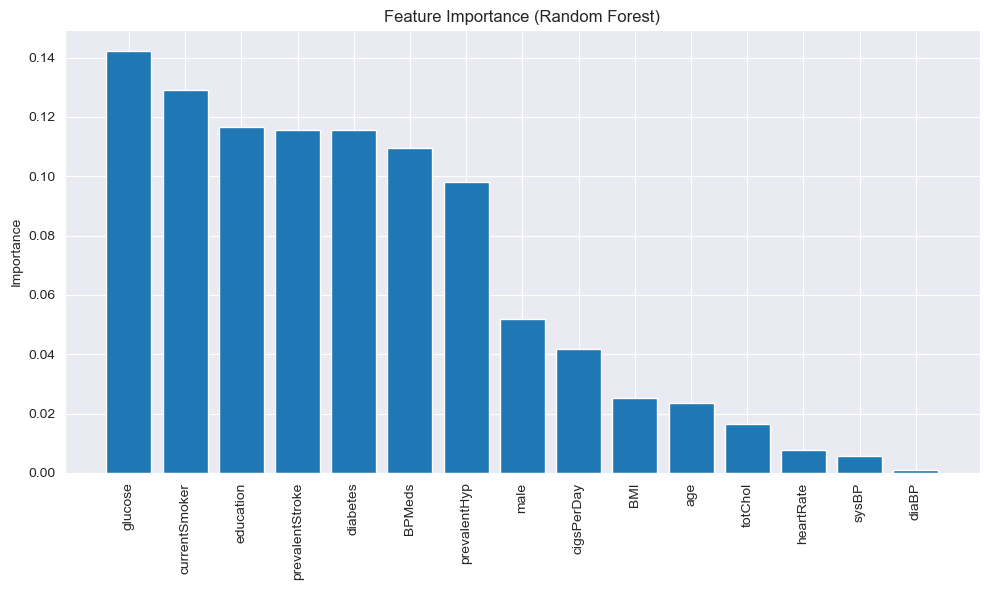

Saved final Random Forest model to ../models/random_forest_best_model_subsampling.pkl
Saved grid search results to ../results/random_forest_repeated_subsampling.csv


In [7]:
# --- 03_random_forest_tune_trees.ipynb ---

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

X_train_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate',
                   'glucose', 'male', 'education', 'currentSmoker', 'BPMeds',
                   'prevalentStroke', 'prevalentHyp', 'diabetes']

X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_train_columns)

# 2. Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
}

print("Starting repeated sub-sampling with GridSearch for Random Forest...")
results_list = []
best_models = []

for seed in range(20):
    print(f"\n--- Seed {seed} ---")

    # Subsampling
    X_minority = X_train[y_train == 1]
    y_minority = y_train[y_train == 1]
    X_majority = X_train[y_train == 0]
    y_majority = y_train[y_train == 0]

    X_majority_downsampled, y_majority_downsampled = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=len(X_minority),
        random_state=seed
    )

    X_resampled = pd.concat([
        pd.DataFrame(X_majority_downsampled, columns=X_train_columns),
        pd.DataFrame(X_minority, columns=X_train_columns)
    ], ignore_index=True)
    y_resampled = np.concatenate([y_majority_downsampled, y_minority])

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=seed),
        param_grid,
        scoring='f1',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    grid_search.fit(X_resampled, y_resampled)
    best_model = grid_search.best_estimator_
    y_test_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_test_pred)

    results_list.append({
        'seed': seed,
        'n_estimators': grid_search.best_params_['n_estimators'],
        'f1_score': f1
    })

    best_models.append(best_model)

# Select the best model
best_idx = np.argmax([r['f1_score'] for r in results_list])
final_model = best_models[best_idx]
final_pred = final_model.predict(X_test)

# Evaluation
print("\nClassification Report (best F1 across seeds):")
print(classification_report(y_test, final_pred))

cm = confusion_matrix(y_test, final_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (best Random Forest)")
plt.show()

# Feature importance
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [X_train_columns[i] for i in indices], rotation=90)
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Save model
os.makedirs("../models", exist_ok=True)
joblib.dump(final_model, "../models/random_forest_best_model_subsampling.pkl")
print("Saved final Random Forest model to ../models/random_forest_best_model_subsampling.pkl")

# Save results
results_df = pd.DataFrame(results_list)
results_df.to_csv("../results/random_forest_repeated_subsampling.csv", index=False)
print("Saved grid search results to ../results/random_forest_repeated_subsampling.csv")